### Setup Freyberg pilot points to use regularization and see what happens...

With our first attempt at pilot points, we saw shitty results.  So lets see if we can fix the problem by using regularization

In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_2/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S.

/Users/jwhite/Dev/python/pyemu/pyemu/pst/pst_utils.py:419: UserWarning: pst_from_io_files has moved to pyemu.helpers and is also now avaiable as a Pst class method (Pst.from_io_files())
  "now avaiable as a Pst class method (Pst.from_io_files())")


starting interp point loop for 800 points
took 2.363018 seconds
run():./pestchek freyberg_pp.pst
run():./pestpp freyberg_pp.init.pst


In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))

In the ``intro_to_regularization``, we talked about two common forms of regularization.  Here we will add both types to the control file.  

Now let's add a few preferred value equations for the recharge and well flux parameters:

In [4]:
pst.parameter_data.pargp.unique()

array(['rch', 'hk', 'w0', 'w1'], dtype=object)

In [5]:
pyemu.helpers.zero_order_tikhonov(pst,par_groups=["rch","w0","w1"])
#pyemu.helpers.zero_order_tikhonov(pst)

In [6]:
pst.prior_information

,equation,obgnme,pilbl,weight
pilbl,,,,
rch_0,1.0 * log(rch_0) = 0.000000E+00,regulrch,rch_0,4.507576
rch_1,1.0 * log(rch_1) = 0.000000E+00,regulrch,rch_1,4.507576
w0_r09_c16,1.0 * log(w0_r09_c16) = 0.000000E+00,regulw0,w0_r09_c16,4.507576
w0_r11_c13,1.0 * log(w0_r11_c13) = 0.000000E+00,regulw0,w0_r11_c13,4.507576
w0_r20_c14,1.0 * log(w0_r20_c14) = 0.000000E+00,regulw0,w0_r20_c14,4.507576
w0_r26_c10,1.0 * log(w0_r26_c10) = 0.000000E+00,regulw0,w0_r26_c10,4.507576
w0_r29_c06,1.0 * log(w0_r29_c06) = 0.000000E+00,regulw0,w0_r29_c06,4.507576
w0_r34_c12,1.0 * log(w0_r34_c12) = 0.000000E+00,regulw0,w0_r34_c12,4.507576
w1_r09_c16,1.0 * log(w1_r09_c16) = 0.000000E+00,regulw1,w1_r09_c16,4.507576


Now, let's add preferred difference regularization to the spatially distributed parameters

In [7]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
df_pp = pyemu.gw_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
cov = gs.covariance_matrix(df_pp.x,df_pp.y,df_pp.parnme)
pyemu.helpers.first_order_pearson_tikhonov(pst,cov,reset=False)
pst.prior_information

,equation,obgnme,pilbl,weight
pilbl,,,,
rch_0,1.0 * log(rch_0) = 0.000000E+00,regulrch,rch_0,4.507576
rch_1,1.0 * log(rch_1) = 0.000000E+00,regulrch,rch_1,4.507576
w0_r09_c16,1.0 * log(w0_r09_c16) = 0.000000E+00,regulw0,w0_r09_c16,4.507576
w0_r11_c13,1.0 * log(w0_r11_c13) = 0.000000E+00,regulw0,w0_r11_c13,4.507576
w0_r20_c14,1.0 * log(w0_r20_c14) = 0.000000E+00,regulw0,w0_r20_c14,4.507576
w0_r26_c10,1.0 * log(w0_r26_c10) = 0.000000E+00,regulw0,w0_r26_c10,4.507576
w0_r29_c06,1.0 * log(w0_r29_c06) = 0.000000E+00,regulw0,w0_r29_c06,4.507576
w0_r34_c12,1.0 * log(w0_r34_c12) = 0.000000E+00,regulw0,w0_r34_c12,4.507576
w1_r09_c16,1.0 * log(w1_r09_c16) = 0.000000E+00,regulw1,w1_r09_c16,4.507576


Now we need to adjust the inputs to pest the control how regularization is enforced.  The big knob is ``phimlim``.  But first, we need to change the estimation mode to "regularization"

In [8]:
pst.control_data.pestmode = "regularization"
pst.reg_data.phimlim

1e-10

That's no good - way too low - just a "placeholder" value.  Theoritically, it should be the number of non-zero weighted obs, but we saw in the non-regularized pilot point run, we are only able to get to about 55, which is much greater than number of non-zero weighted obs, so let's try 100.0:

In [28]:
pst.reg_data.phimlim = 100.0
pst.reg_data.phimaccept = 150.0
pst.svd_data.maxsing = 3

In [10]:
pst.write(os.path.join(working_dir,pst_name))

In [11]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir='.')
os.chdir("..")

master:pestpp freyberg_pp.pst /h :4004 in .
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_14


In [12]:
os.chdir(working_dir)
pst.parrep(pst_name.replace(".pst",".parb"))
pyemu.pst_utils.write_parvals_in_tplfiles(pst)
pyemu.gw_utils.fac2real("hkpp.dat",factors_file="hkpp.dat.fac",out_file="hk_layer_1.ref")
os.chdir("..")

In [ ]:
ax = plt.subplot(111,aspect="equal") 
wl_names = [n for n in pst.nnz_obs_names if n.startswith("c")]
ax.scatter(pst.res.loc[wl_names,"modelled"],pst.res.loc[wl_names,"measured"],marker='.')
ylim,xlim = ax.get_ylim(),ax.get_xlim()
mn = min(ylim[0],xlim[0])
mx = max(ylim[1],xlim[1])
ax.plot([mn,mx],[mn,mx])
ax.set_ylim(mn,mx)
ax.set_xlim(mn,mx)

Let's see how the parameter values look

In [14]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)

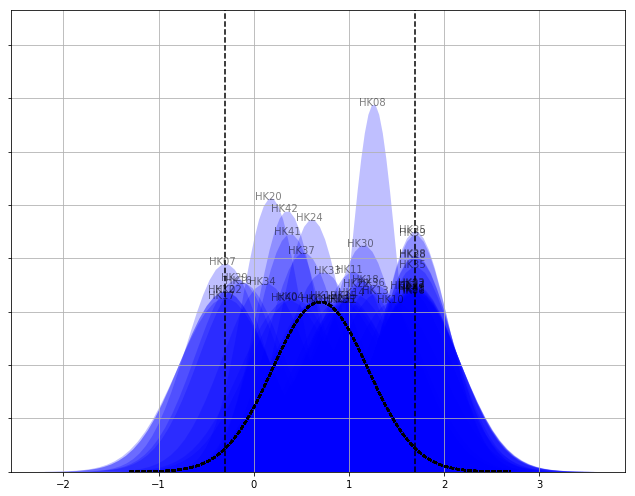

In [15]:
hk_pars = [p.upper() for p in pst.par_names if p.startswith("hk")]
df_hk = df_paru.loc[hk_pars,:]
ax = pyemu.helpers.plot_summary_distributions(df_hk,label_post=True)
mn = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parlbnd"])
mx = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parubnd"])
ax.plot([mn,mn],ax.get_ylim(),"k--")
ax.plot([mx,mx],ax.get_ylim(),"k--")

Not a good sign...lots of parameters are at their bounds...

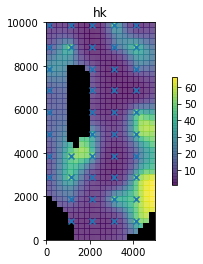

In [16]:
df_pp = pyemu.gw_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

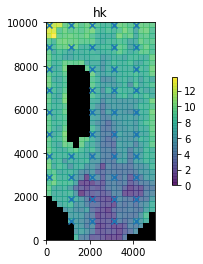

In [17]:
m.upw.hk[0] = os.path.join(fs.BASE_MODEL_DIR,"hk.truth.ref")
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

oh no!!!!!  We are still over fit...so let's back off the fit using ``phimilim``.  But first, just for fun, let's look at the forecast uncertainty

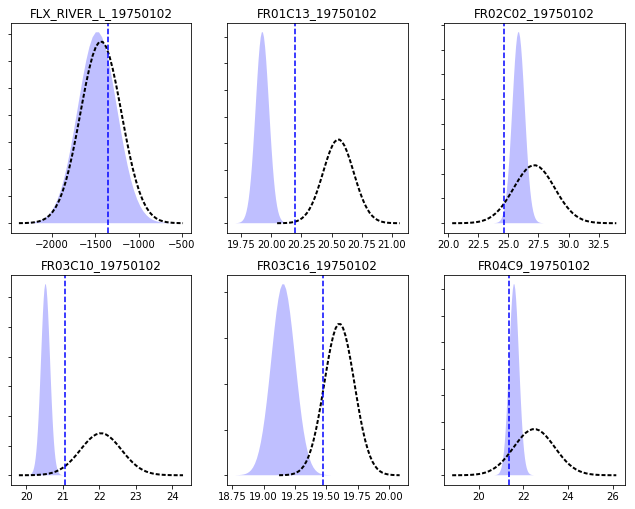

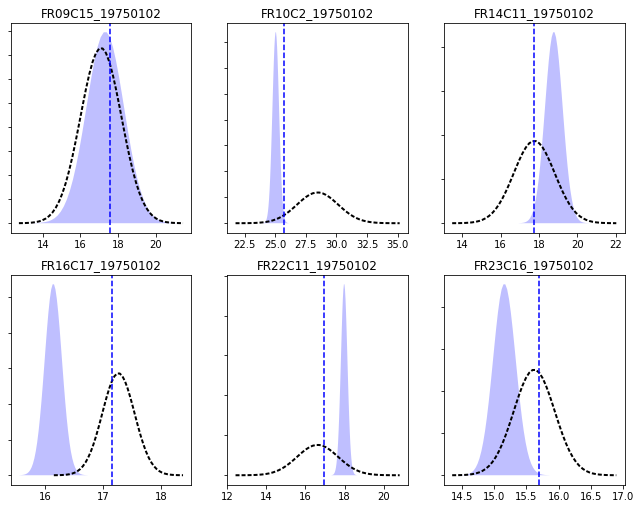

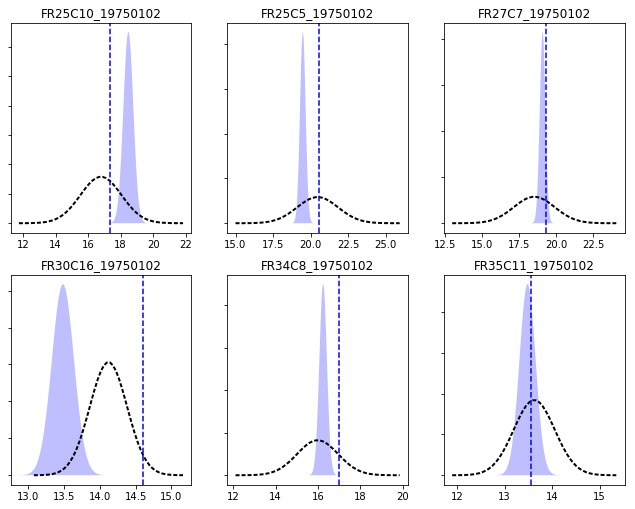

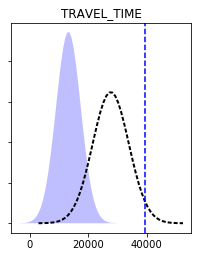

In [18]:
figs, axes = pyemu.helpers.plot_summary_distributions(os.path.join(working_dir,
                    pst_name.replace(".pst",".pred.usum.csv")),subplots=True)
for ax in axes:
    fname = ax.get_title().lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"b--")
    ax.set_ylim(ylim)

We are crushing the posterior uncertainty - it is considerable less than the prior for several forecasts. But, compared to the "truth", we are not doing well - the model is not reliable for many forecasts

# Adjust ``phimlim`` and rerun..

Let's turn up ``phimlim`` and see if we can eliminate our overfitting problem.  How will we know we have eliminated it? In the real world, we will never know...

In [19]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.reg_data.phimlim = 500.0
pst.reg_data.phimaccept = 550.0
pst.reg_data.fracphim = 0.75
pst.svd_data.maxsing = 2
pst.write(os.path.join(working_dir,pst_name))


In [20]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir='.')
os.chdir("..")

master:pestpp freyberg_pp.pst /h :4004 in .
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_14


In [21]:
os.chdir(working_dir)
pst.parrep(pst_name.replace(".pst",".parb"))
pyemu.pst_utils.write_parvals_in_tplfiles(pst)
pyemu.gw_utils.fac2real("hkpp.dat",factors_file="hkpp.dat.fac",out_file="hk_layer_1.ref")
os.chdir("..")


In [22]:
pst.phi

502.13116043387924

In [ ]:
ax = plt.subplot(111,aspect="equal") 
wl_names = [n for n in pst.nnz_obs_names if n.startswith("c")]
ax.scatter(pst.res.loc[wl_names,"modelled"],pst.res.loc[wl_names,"measured"],marker='.')
ylim,xlim = ax.get_ylim(),ax.get_xlim()
mn = min(ylim[0],xlim[0])
mx = max(ylim[1],xlim[1])
ax.plot([mn,mx],[mn,mx])
ax.set_ylim(mn,mx)
ax.set_xlim(mn,mx)

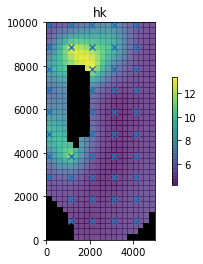

In [23]:
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

That's much better...

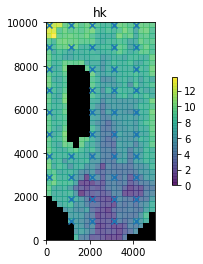

In [24]:
m.upw.hk[0] = os.path.join(fs.BASE_MODEL_DIR,"hk.truth.ref")
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

Now let's see how the uncertainty looks...

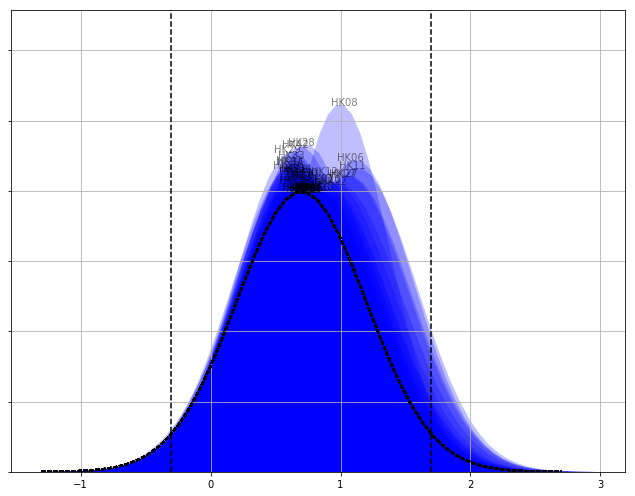

In [25]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
hk_pars = [p.upper() for p in pst.par_names if p.startswith("hk")]
df_hk = df_paru.loc[hk_pars,:]
ax = pyemu.helpers.plot_summary_distributions(df_hk,label_post=True)
mn = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parlbnd"])
mx = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parubnd"])
ax.plot([mn,mn],ax.get_ylim(),"k--")
ax.plot([mx,mx],ax.get_ylim(),"k--")

Ahh yeah!

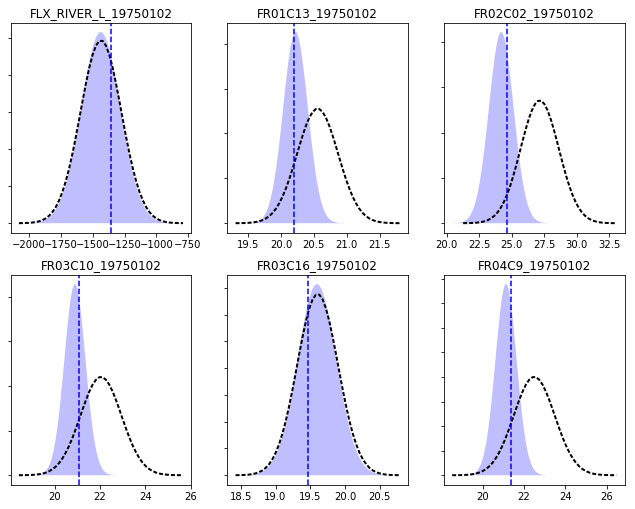

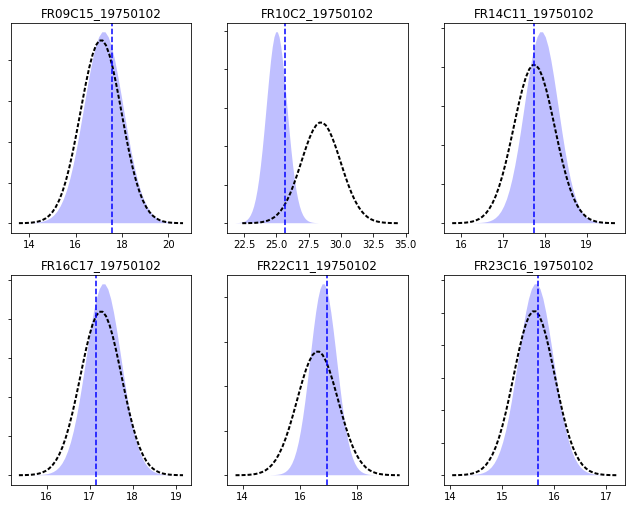

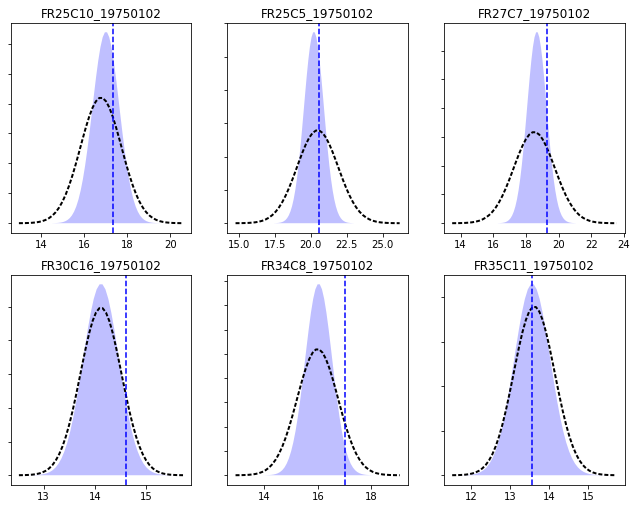

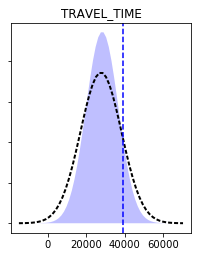

In [26]:
figs, axes = pyemu.helpers.plot_summary_distributions(os.path.join(working_dir,
                    pst_name.replace(".pst",".pred.usum.csv")),subplots=True)
for ax in axes:
    fname = ax.get_title().lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"b--")
    ax.set_ylim(ylim)

What happened?  Posterior uncertainty is significanty higher compared to the overfit case above.  This is because the FOSM calculations in pestpp adjust the elements of the $\boldsymbol{\Sigma}_{\epsilon}$ (measurement noise covariance matrix) so that the variances reflect how well the model can reproduce the observations.  That is, the weight of an observation is decreased if the model can't reproduce the observation...By increasing the variance (uncertainy) of the obserations, posterior parameter (and therefore posterior forecast) uncertainty is not reduced as much.  Put another way, if an observation are uncertain, then we shouldn't use the information from it. 

But...we are now bracketing the "truth" with significant probability for each forecast (FINALLY!!!). So, even though we aren't fitting the observations as well (hence posterior uncertainty), we are doing much better from a reliability stand point. 